In [1]:
import numpy as np
from mflex.simulate.simulate_boundary import dalmatian

In [2]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 2.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 2.0
zmin = 0.0
zmax = 2.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

# Background atmosphere parameters
z0 = 0.2
deltaz = 0.02

b = 1.0
a = 0.22
alpha = 0.5

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin

# data_bz = np.zeros((nresol_y, nresol_x))

# for ix in range(0, nresol_x):
#     for iy in range(0, nresol_y):
#         x = x_arr[ix]
#         y = y_arr[iy]
#         data_bz[iy, ix] = dalmatian(x, y)

In [3]:
print(pixelsize_x)

0.01


In [4]:
# with open("/Users/lilli/Desktop/mflex/mhsflex/testfile.npy", "wb") as file:
#     np.array([nresol_x, nresol_y, nresol_z], dtype=np.int32).tofile(file)
#     np.array([pixelsize_x, pixelsize_y, pixelsize_z], dtype=np.float64).tofile(file)
#     data_bz.tofile(file)
#     x_arr.tofile(file)
#     y_arr.tofile(file)
#     z_arr.tofile(file)

In [5]:
from mhsflex.field3d import Field3d

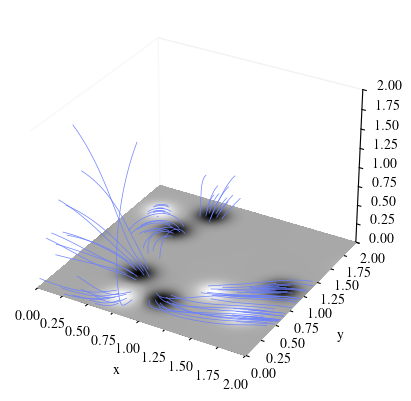

In [7]:
Field3d("/Users/lilli/Desktop/mflex/mhsflex/testfile.npy", a, b, alpha, z0, deltaz)